# Lab03: Logistic Regression.

- Student ID: 19127611
- Student name: Phạm Minh Tú

**How to do your homework**


You will work directly on this notebook; the word `TODO` indicate the parts you need to do.

You can discuss ideas with classmates as well as finding information from the internet, book, etc...; but *this homework must be your*.

**How to submit your homework**

Before submitting, rerun the notebook (`Kernel` ->` Restart & Run All`).

Then create a folder named `ID` (for example, if your ID is 1234567, then name the folder `1234567`). Copy file notebook to this folder, compress and submit it on moodle.

**Contents:**
- Logistic Regression.

## 1. Feature Extraction

### Import Library

In [71]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 

### Load data

In [72]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', return_X_y=True)

In [73]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


### Extract Features

So we basically have 70000 samples with each sample having 784 features - pixels in this case and a label - the digit the image represent.

Let’s play around and see if we can extract any features from the pixels that can be more informative. First I’d like to know more about average intensity - that is the average value of a pixel in an image for the different digits

In [74]:
labels=np.unique(y)
# print(labels)
n_label=np.unique(y).shape[0]
l_means=np.zeros(shape=n_label,dtype=float) #array stores average intensity for each label

#TODO compute average intensity for each label
t = np.zeros(n_label)
count = np.zeros(n_label)

for i in range(9, len(y)):
    count[int(y[i])] += 1
    t[int(y[i])] += X.iloc[i].mean()

for i in range(0, len(t)):
    l_means[i] = t[i] / count[i]

print(l_means)

[44.17805934 19.40680012 38.03424751 36.15286561 30.99690797 32.9498168
 35.23486491 29.21798737 38.39790125 31.35965959]


Plot the average intensity using matplotlib

<BarContainer object of 10 artists>

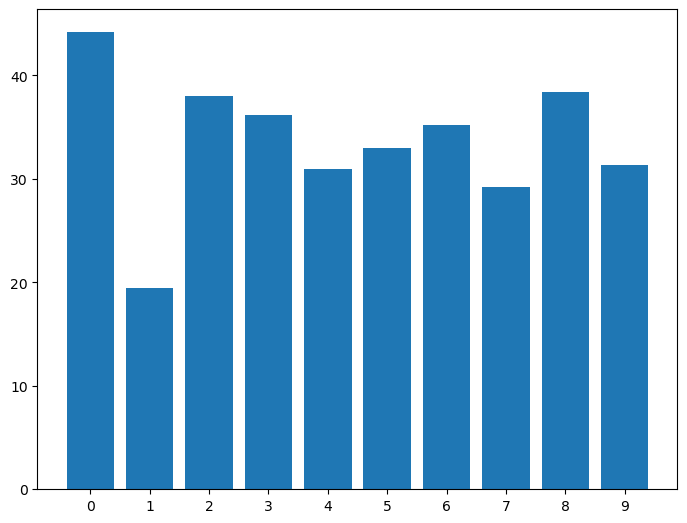

In [75]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(labels,l_means)

As we can see there are some differences in intensity. The digit “1” is the less intense while the digit “0” is the most intense. So this new feature seems to have some predictive value if you wanted to know if say your digit is a “1” or not.

In [76]:
#TODO compute average intensity for each data sample
# intensity=?
intensity = np.array(X.sum(axis = 1))
print(intensity.shape)

(70000,)


Sometimes people really do not know what are they doing. I am not an exception:

In [77]:
X_flip=np.flip(np.array(X))
symmetry= np.mean((X-X_flip),axis=1)
print(symmetry.shape)

(70000,)


I called this feature "symmetry" (though it's not "symmetry" at all). Use visualization method to understand why this feature work.

Our new trainning data will have 70000 samples and 2 features: intensity, symmetry.

In [78]:
#TODO create X_new by horizontal stack intensity and symmetry
X_new = np.array([intensity, symmetry]).T
print(X_new.shape) #it should be (70000,2)

(70000, 2)


## 2. Training 

Usually logistic regression is a good first choice for classification. In this homework we use logistic regression for classifying digit 1 images and not digit 1 images.

### Normalize data
First normalize data using Z-score normalization
- **TODO: Study about Z-score normalization**
- **TODO: Why should we normalize data?**

Z-score normalization là quá trình thay đổi quy mô dataset ̣(tất cả datapoints) để chúng có các thuộc tính của phân phối chuẩn chuẩn (giá trị trung bình là 0 và độ lệch chuẩn là 1).
$$ z = \frac{x - \mu}{\sigma}$$
Trong đó: 
- x: Gía trị ta quan sát
- $\sigma$: Độ lệch chuẩn
- $\mu$: Giá trị trung bình

Nếu Z < 0: tất cả datatpoint nằm bên trái giá trị trung bình
Nếu Z > 0: tất cả datatpoint nằm bên phải giá trị trung bình

Chúng ta nên chuẩn hóa dữ liêu trước khi tính toán vì chúng ta phải đưa tất cả những dặc trưng trong công thức về một đơn vị / tỉ lệ thích hơp, có thể tăng tốc quá trình tìm điểm global/local minimum khi sử dụng gradient descent, giúp tính toán nhanh hơn và giảm viêc overflow trong khi tính toán 

In [79]:
#TODO: normalize X_new
X_mean = np.mean(X_new, axis = 0)
X_std = np.std(X_new, axis = 0)

for i in range(X_new.shape[0]):
    for j in range(X_new.shape[1]):
        X_new[i][j] = (X_new[i][j] - X_mean[j]) / X_std[j]   

X_new

array([[ 0.15575488, -1.15048332],
       [ 0.56751688,  0.36473248],
       [-0.77641894, -0.78703737],
       ...,
       [ 0.35252406,  0.78703737],
       [ 0.04433692, -0.36473248],
       [ 1.8060324 ,  1.15048332]])

### Construct  data

In [80]:
X_new = np.hstack((np.ones((len(X_new), 1)), X_new)) #stack 1s column as usual
y_new=y.astype(int)
y_new[y_new != 1] = 0 # digit 1 -> class 1, other digits -> class 0
y_new=np.array(y_new).reshape(-1,1)
print (X_new.shape)
print (y_new.shape)

(70000, 3)
(70000, 1)


### Split data 

In [81]:
train_X, test_X, train_y, test_y = train_test_split(X_new, y_new, test_size= int(1/3*X.shape[0]))
print(train_X.shape)
print(train_y.shape)

(46667, 3)
(46667, 1)


### Sigmoid function and derivative of the sigmoid function

In [82]:
def sigmoid_activation(x):
    """compute the sigmoid activation value for a given input"""
    return 1.0 / (1 + np.exp(-x))
def sigmoid_deriv(x):
    '''compute the derivative of the sigmoid function ASSUMING
    that the input ‘x‘ has already been passed through the sigmoid
    activation function'''
    return x * (1 - x)

### Compute output

In [83]:
def compute_h(W, X):
    """
    Compute output: Take the dot product between our features ‘X‘ and the weight
    matrix ‘W‘, then pass this value through our sigmoid activation function 
    """
    return sigmoid_activation(X.dot(W))
def predict(W, X):
 
    '''Take the dot product between our features and weight matrix, 
       then pass this value through our sigmoid activation'''
    #........
    preds=sigmoid_activation(X.dot(W))
    # apply a step function to threshold the outputs to binary
    # class labels
    preds[preds <= 0.5] = 0
    preds[preds > 0] = 1

    return preds

### Compute gradient

**Loss Function: Average negative log likelihood**
$$\mathcal{L}=\dfrac{1}{N} \sum_{i=1}^{N} -\left(y^{i}\ln h_{\mathbf{w}}\left(\mathbf{x}^{i}\right)+\left(1-y^{i}\right)\ln \left(1-h_{\mathbf{w}}\left(x^{i}\right)\right)\right) $$


$$\text{Sigmoid Activation: } z= \sigma \left(h\right)= \dfrac{1}{1+e^{-h}}$$

$$\text{Cross-entropy: } J(w)=-\left({ylog(z)+(1-y)log(1-z)}\right)$$

$$\text{Chain rule: } \dfrac{\partial J(w)}{\partial w}=\dfrac{\partial J(w)}{\partial z} \dfrac{\partial z}{\partial h}\dfrac{\partial h}{\partial w}  $$

$$\dfrac{\partial J(w)}{\partial z}=-\left(\dfrac{y}{z}-\dfrac{1-y}{1-z}\right)=\dfrac{z-y}{z(1-z)}$$

$$\dfrac{\partial z}{\partial h}=z(1-z)$$

$$\dfrac{\partial h}{\partial w}=X$$

$$\dfrac{\partial J(w)}{\partial w}=X^T(z-y)$$

In [84]:
def compute_gradient(train_X, error):
    """
    This is the gradient descent update of "average negative loglikelihood" loss function. 
    In lab02 our loss function is "sum squared error".
    """
    #TODO
    gradient = (1.0 / len(train_X)) * np.dot(train_X.T, error)
    return gradient

In [85]:
def train(W,train_X, train_y, learning_rate, num_epochs, losses):
    for epoch in np.arange(0, num_epochs):
        h=compute_h(W,train_X)
        error = h - train_y
        loss = np.mean(- train_y * np.log(h) - (1 - train_y) * np.log(1 - h))
        losses.append(loss)
        gradient=compute_gradient(h, error)
        W += -learning_rate * gradient
        if ((epoch+1)%1000==0): print ('Epoch %d, loss %.3f' %(epoch+1, loss))
        
    return W

### Train our model

In [86]:
W = np.random.randn(train_X.shape[1], 1)
losses=[]
num_epochs=40000
learning_rate=0.01
W=train(W,train_X, train_y, learning_rate, num_epochs , losses)
x_preds=predict(W ,train_X)
train_err = np.mean(x_preds != train_y) * 100
print ('=' * 50)
print ('Train err of final w: ', train_err)

Epoch 1000, loss 0.735
Epoch 2000, loss 1.043
Epoch 3000, loss 1.406


c:\Users\fminhtu\miniconda3\envs\min_env\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
c:\Users\fminhtu\miniconda3\envs\min_env\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


Epoch 4000, loss nan
Epoch 5000, loss nan
Epoch 6000, loss nan
Epoch 7000, loss nan
Epoch 8000, loss nan
Epoch 9000, loss nan
Epoch 10000, loss nan
Epoch 11000, loss nan
Epoch 12000, loss nan
Epoch 13000, loss nan
Epoch 14000, loss nan
Epoch 15000, loss nan
Epoch 16000, loss nan
Epoch 17000, loss nan
Epoch 18000, loss nan
Epoch 19000, loss nan
Epoch 20000, loss nan
Epoch 21000, loss nan
Epoch 22000, loss nan
Epoch 23000, loss nan
Epoch 24000, loss nan
Epoch 25000, loss nan
Epoch 26000, loss nan
Epoch 27000, loss nan
Epoch 28000, loss nan
Epoch 29000, loss nan
Epoch 30000, loss nan
Epoch 31000, loss nan
Epoch 32000, loss nan


c:\Users\fminhtu\miniconda3\envs\min_env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 33000, loss nan
Epoch 34000, loss nan
Epoch 35000, loss nan
Epoch 36000, loss nan
Epoch 37000, loss nan
Epoch 38000, loss nan
Epoch 39000, loss nan
Epoch 40000, loss nan
Train err of final w:  23.40626138384726


## 3. Evaluate our model

In [87]:
preds = predict(W, train_X)
print(classification_report(train_y, preds))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85     41534
           1       0.30      0.86      0.45      5133

    accuracy                           0.77     46667
   macro avg       0.64      0.81      0.65     46667
weighted avg       0.90      0.77      0.81     46667



c:\Users\fminhtu\miniconda3\envs\min_env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


In [88]:
preds = predict(W, test_X)
print(classification_report(test_y, preds))

c:\Users\fminhtu\miniconda3\envs\min_env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

           0       0.97      0.76      0.85     20589
           1       0.32      0.85      0.46      2744

    accuracy                           0.77     23333
   macro avg       0.65      0.80      0.66     23333
weighted avg       0.90      0.77      0.81     23333



**TODO: Comment on the result**

Nhận xét:
- Cột support cho thấy tập dữ liệu không cân đối
- Class 0 có precision,recall, f1-score cao hơn class 1
- Mô hình này phát hiện 'không phải là chữ số 1' sẽ tốt hơn 'là số 1' \
Nhìn vào precision, recall và f1-score, do dữ liệu không cân đối và mô hình đơn giản, ta cần cải thiện tập dữ liệu phù hợp hơn 

## Tham khảo:
- https://machinelearningcoban.com/2017/01/27/logisticregression/
- https://ml-concepts.com/2021/10/08/z-score-normalization/
- https://t4tutorials.com/z-score-normalization-data-mining/  